In [12]:
from pathlib import Path
import pandas as pd
import os

BASE = Path(os.path.expanduser("~/Library/Mobile Documents/com~apple~CloudDocs/Documents"))
ARCHIVO = BASE / "Aquifer_Auser.xlsx"

try:
    # Usamos sheet_name=0 para cargar la primera pestaña disponible
    Df = pd.read_excel(ARCHIVO, sheet_name=0) 
    
    print(Df.head(2).to_string(index=False))

except Exception as e:
    print(f"Ocurrió un error: {e}")

Aquifer_Auser         Unnamed: 1          Unnamed: 2           Unnamed: 3        Unnamed: 4               Unnamed: 5         Unnamed: 6         Unnamed: 7            Unnamed: 8                              Unnamed: 9                   Unnamed: 10              Unnamed: 11              Unnamed: 12              Unnamed: 13              Unnamed: 14               Unnamed: 15          Unnamed: 16             Unnamed: 17                 Unnamed: 18                     Unnamed: 19 Unnamed: 20 Unnamed: 21 Unnamed: 22 Unnamed: 23 Unnamed: 24                Unnamed: 25          Unnamed: 26
         Date Rainfall_Gallicano Rainfall_Pontetetto Rainfall_Monte_Serra Rainfall_Orentano Rainfall_Borgo_a_Mozzano Rainfall_Piaggione Rainfall_Calavorno Rainfall_Croce_Arcana Rainfall_Tereglio_Coreglia_Antelminelli Rainfall_Fabbriche_di_Vallico Depth_to_Groundwater_LT2 Depth_to_Groundwater_SAL Depth_to_Groundwater_PAG Depth_to_Groundwater_CoS Depth_to_Groundwater_DIEC Temperature_Orentano Temperature_Monte_Se


--- Resultados del Forecast ---
MAE (Error Absoluto Medio): 0.3267
RMSE (Raíz del Error Cuadrático Medio): 0.9347


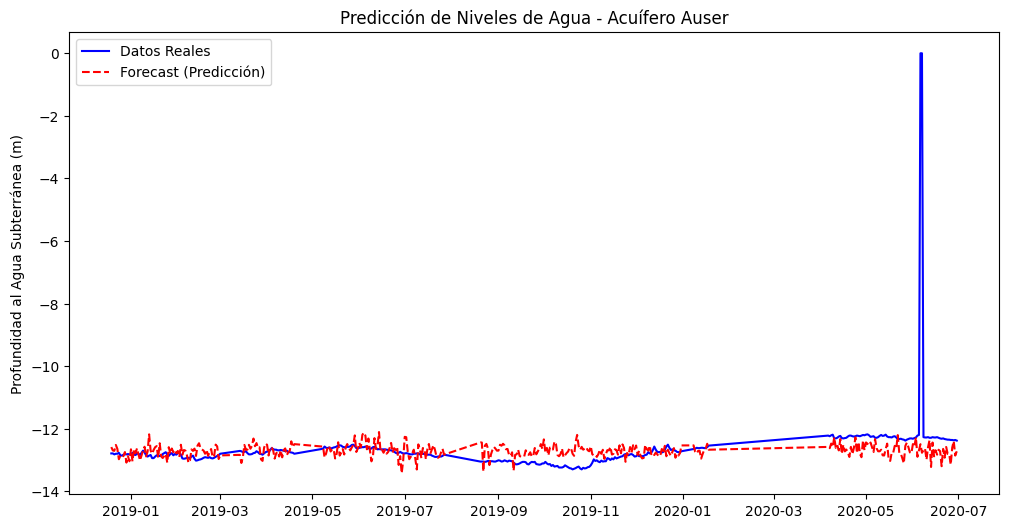

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

BASE = Path(os.path.expanduser("~/Library/Mobile Documents/com~apple~CloudDocs/Documents"))
ARCHIVO = BASE / "Aquifer_Auser.xlsx"

def generar_forecast_auser():
    try:
        df = pd.read_excel(ARCHIVO, sheet_name=0, skiprows=1)
        df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
        df = df.sort_values('Date')
        
        target = 'Depth_to_Groundwater_LT2'
        
        df = df.dropna(subset=[target])


        rainfall_cols = [col for col in df.columns if 'Rainfall' in col]
        df['Rainfall_Avg'] = df[rainfall_cols].mean(axis=1)
        
        df['Rainfall_Lag_7'] = df['Rainfall_Avg'].shift(7)
        df['Rainfall_Lag_30'] = df['Rainfall_Avg'].shift(30)
        
        df = df.dropna()

        features = ['Rainfall_Avg', 'Rainfall_Lag_7', 'Rainfall_Lag_30', 'Temperature_Monte_Serra']
        X = df[features]
        y = df[target]

        split = int(len(df) * 0.8)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        predictions = model.predict(X_test)

        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        
        print(f"\n--- Resultados del Forecast ---")
        print(f"MAE (Error Absoluto Medio): {mae:.4f}")
        print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.4f}")

        plt.figure(figsize=(12, 6))
        plt.plot(df['Date'].iloc[split:], y_test.values, label='Datos Reales', color='blue')
        plt.plot(df['Date'].iloc[split:], predictions, label='Forecast (Predicción)', color='red', linestyle='--')
        plt.title('Predicción de Niveles de Agua - Acuífero Auser')
        plt.ylabel('Profundidad al Agua Subterránea (m)')
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    generar_forecast_auser()


--- Desempeño del Forecast (Depth_to_Groundwater_LT2) ---
Error Absoluto Medio (MAE): 0.3267
Raíz del Error Cuadrático Medio (RMSE): 0.9347


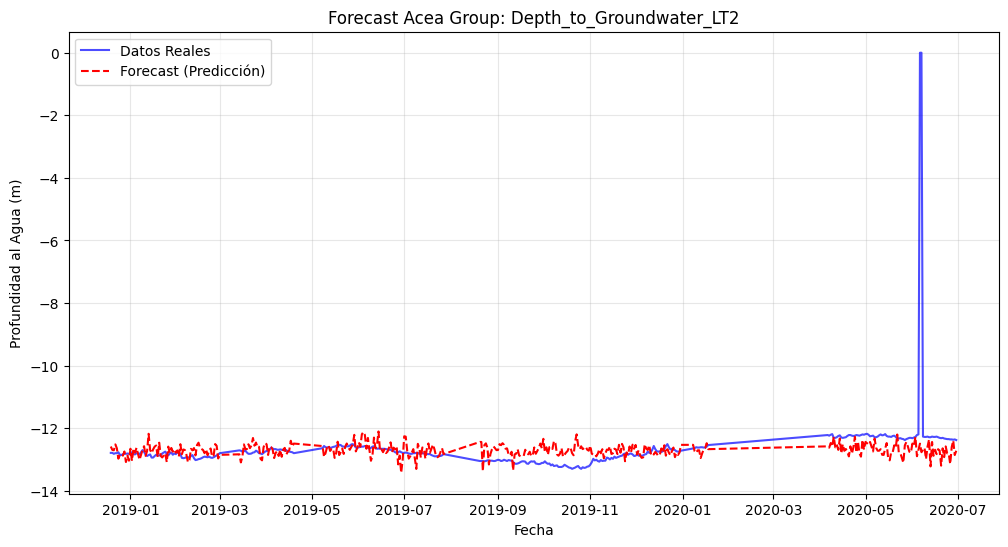

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. CONFIGURACIÓN DE RUTA (Ajustada a tu entorno de iCloud)
BASE = Path(os.path.expanduser("~/Library/Mobile Documents/com~apple~CloudDocs/Documents"))
ARCHIVO = BASE / "Aquifer_Auser.xlsx"

def generar_forecast_completo():
    try:
        # 2. CARGA Y LIMPIEZA DE CABECERAS
        # Usamos skiprows=1 porque tus datos tienen una fila extra que genera 'Unnamed'
        df = pd.read_excel(ARCHIVO, sheet_name=0, skiprows=1)
        
        # Convertir fecha y limpiar nulos en el objetivo
        df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
        target = 'Depth_to_Groundwater_LT2'
        df = df.dropna(subset=[target])
        df = df.sort_values('Date')

        # 3. INGENIERÍA DE CARACTERÍSTICAS (Educativo)
        # Los acuíferos tienen memoria; la lluvia de hoy afecta semanas después.
        rainfall_cols = [col for col in df.columns if 'Rainfall' in col]
        df['Rainfall_Avg'] = df[rainfall_cols].mean(axis=1)
        
        # Creamos Lags (retrasos) para darle contexto temporal al modelo
        df['Rainfall_Lag_7'] = df['Rainfall_Avg'].shift(7)
        df['Rainfall_Lag_30'] = df['Rainfall_Avg'].shift(30)
        
        # Eliminamos los nulos creados por los desplazamientos (shifts)
        df = df.dropna()

        # 4. PREPARACIÓN DE VARIABLES
        # Seleccionamos variables clave: Lluvia actual, retrasada y temperatura
        features = ['Rainfall_Avg', 'Rainfall_Lag_7', 'Rainfall_Lag_30', 'Temperature_Monte_Serra']
        X = df[features]
        y = df[target]

        # División temporal: 80% entrenamiento, 20% prueba
        split = int(len(df) * 0.8)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        # 5. ENTRENAMIENTO DEL MODELO (Forecast)
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        # Predicciones
        predictions = model.predict(X_test)

        # 6. MÉTRICAS DE EVALUACIÓN (Requeridas por el proyecto)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        
        print(f"\n--- Desempeño del Forecast ({target}) ---")
        print(f"Error Absoluto Medio (MAE): {mae:.4f}")
        print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")

        # 7. VISUALIZACIÓN FINAL
        plt.figure(figsize=(12, 6))
        plt.plot(df['Date'].iloc[split:], y_test, label='Datos Reales', color='blue', alpha=0.7)
        plt.plot(df['Date'].iloc[split:], predictions, label='Forecast (Predicción)', color='red', linestyle='--')
        plt.title(f'Forecast Acea Group: {target}')
        plt.ylabel('Profundidad al Agua (m)')
        plt.xlabel('Fecha')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    except Exception as e:
        print(f"Ocurrió un error: {e}")

if __name__ == "__main__":
    generar_forecast_completo()